21110429 - Nguyễn Quang Trường

21110286 - Huỳnh Long Hải

-------------------------------


# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1 . Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [ ]:
## load dataset here
df = pd.read_csv("../data/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [ ]:
## parsing data here
images, labels = parse_data(df)

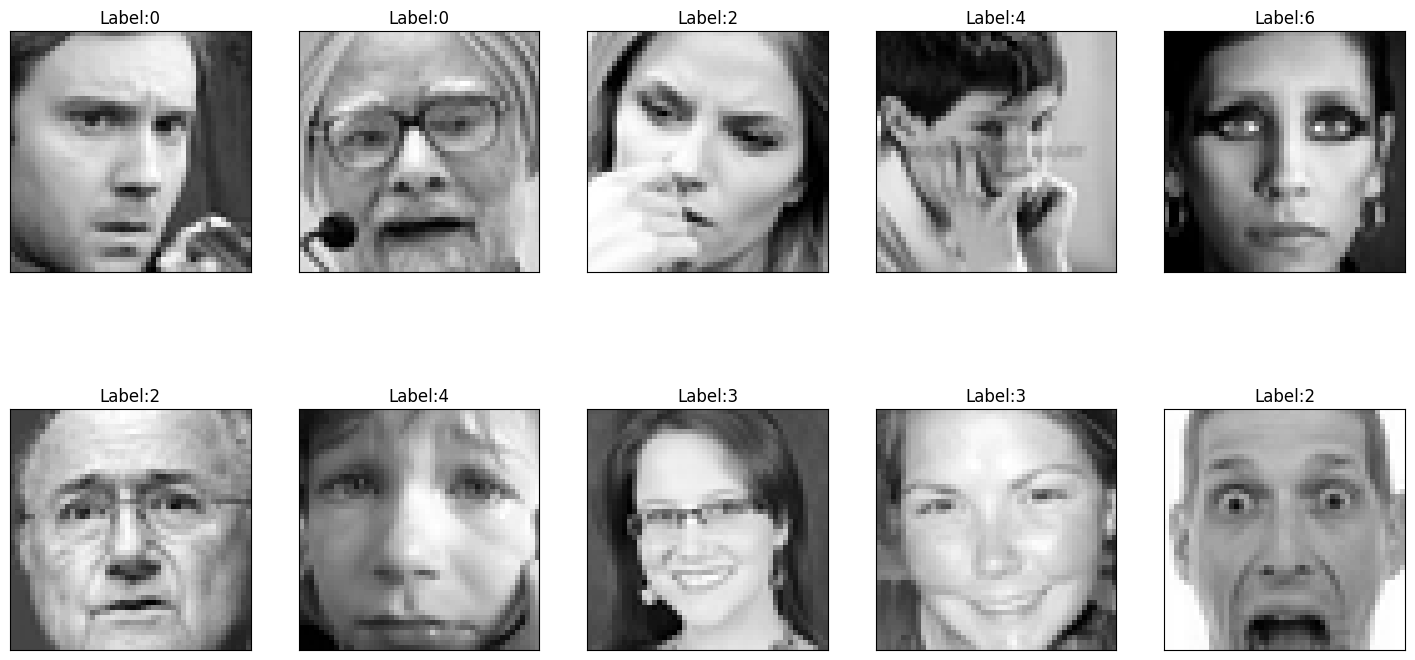

In [ ]:
## showing images here
show_img(images, labels)

### Install required packages

- Install cuML for training in GPU

In [ ]:
!nvidia-smi

Fri Jun 21 13:52:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
# !python rapidsai-csp-utils/colab/pip-install.py

- Install Optuna for effective hyperparameter tuning

In [ ]:
!pip install -q optuna

#### Loading requirements

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import resample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.io import imread, imshow
from skimage.feature import hog
import cv2

import warnings

warnings.filterwarnings("ignore")

## 2 . Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [ ]:
# Flatten & stack images into Numpy array
image_data = np.stack([img.flatten() for img in images])

In [ ]:
pca = PCA(n_components = 2)
pca.fit(image_data) ## modify images' array to the appropriate shape

In [ ]:
label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
labels_txt = [label_names[label] for label in labels]

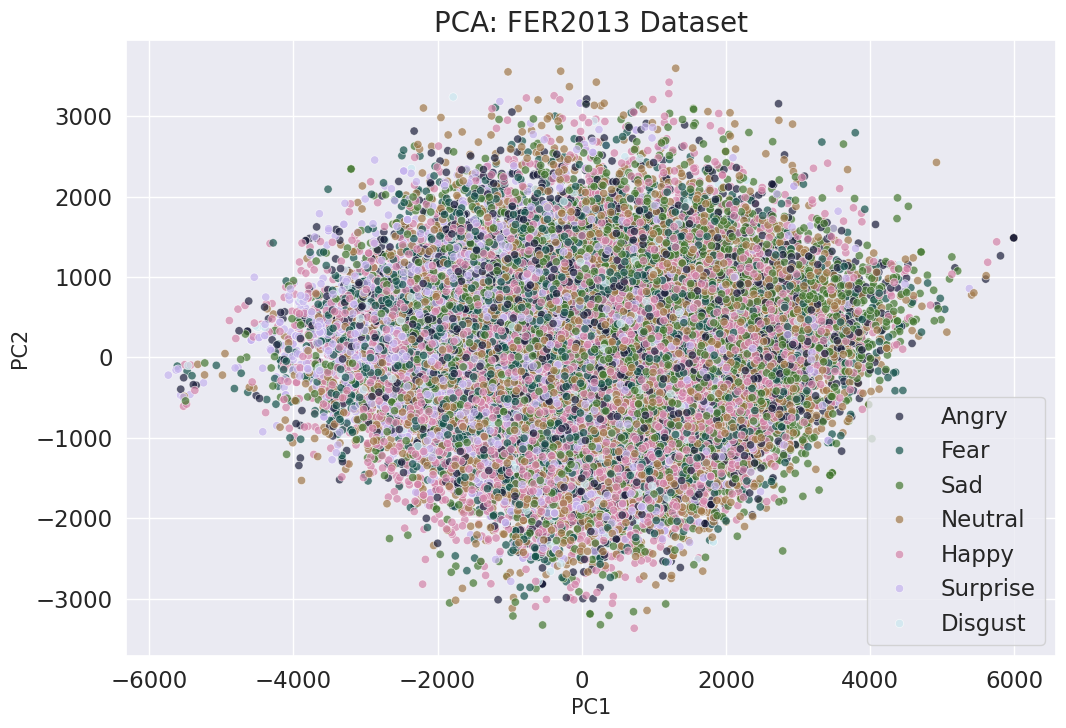

In [ ]:
sns.set(font_scale = 1.5)
figure = plt.figure(figsize = (12, 8))

# Transform image data
X_reduced = pca.transform(image_data)

#visualizing here
sns.scatterplot(
    x = X_reduced[:,0],
    y = X_reduced[:,1],
    hue = labels_txt,
    palette = 'cubehelix',
    alpha = 0.7,
)

plt.legend()
plt.title('PCA: FER2013 Dataset', fontsize = 20)
plt.xlabel('PC1', fontsize = 15); plt.ylabel('PC2', fontsize = 15);

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

> **Eigenfaces:**

> From Abstract of **Paper:** [Matthew Turk and Alex Pentland. Eigenfaces for recognition. Journal of cognitive neuroscience, 3(1):71–86, 1991.](https://direct.mit.edu/jocn/article/3/1/71/3025/Eigenfaces-for-Recognition)
>
>  ...*faces are normally upright and thus may be described by a small set of 2-D characteristic views. The system functions by projecting face images onto a feature space that spans the significant variations among known face images. The significant features are known as "eigenfaces," because they are the eigenvectors (principal components) of the set of faces; they do not necessarily correspond to features such as eyes, ears, and noses...*

A facial image is a point from a high-dimensional image space and a lower-dimensional representation is found, where classification becomes easy. The lower-dimensional subspace is found with Principal Component Analysis, which identifies the axes with maximum variance.

The problem with the image representation we are given is its high dimensionality. Two-dimensional $p×q$ grayscale images span a $m=pq$-dimensional vector space, so an image with $100×100$ pixels lies in a $10,000$-dimensional image space already.
We can only make a decision if there's any variance in data, so what we are looking for are the components that account for most of the information. The Principal Component Analysis (PCA) was independently proposed by Karl Pearson (1901) and Harold Hotelling (1933) to turn a set of possibly correlated variables into a smaller set of uncorrelated variables. The idea is, that a high-dimensional dataset is often described by correlated variables and therefore only a few meaningful dimensions account for most of the information. The PCA method finds the directions with the greatest variance in the data, called principal components.


---------------------
We can reconstruct a face from its lower dimensional approximation. So let's see how many Eigenfaces are needed for a good reconstruction. I'll do a subplot with 10,25,…,295 Eigenfaces:

In [ ]:
def eigenface_reconstruct(image_data, num_components):
    """
    Reconstructs images from the original data using the PCA method with a specified number of principal components.

    Args:
    image_data (numpy array): Input image data array, where each row corresponds to an image.
    num_components (int): The number of principal components (eigenfaces) to use for reconstruction.

    Returns:
    numpy array: Array of reconstructed images, where each row corresponds to a reconstructed image.
    """

    # Perform PCA on the image data
    pca = PCA(n_components=num_components)
    pca.fit(image_data)

    # Transform the image data using PCA
    projected_data = pca.transform(image_data)

    # Reconstruct image using sklearn PCA inverse_transform
    reconstructed_data = pca.inverse_transform(projected_data)
    reconstructed_img = reconstructed_data.reshape(-1, 48, 48)

    return reconstructed_img

In [ ]:
def viz_eigenfaces():

    """
    Visualizes the reconstructed images using different numbers of eigenfaces (principal components).
    """
    plt.figure(figsize=(10, 10))
    plt.title("Reconstruct Image")

    for i in range(20):
        n_comp = 10 + 15*i  # Calculate the number of principal components to use
        reconstruct_images = eigenface_reconstruct(image_data, num_components = n_comp)

        index = 0
        reconstruct_img = Image.fromarray(reconstruct_images[index].astype(np.uint8))

        plt.subplot(4, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(reconstruct_img, cmap='gray')
        plt.xlabel(f'{n_comp} Eigenfaces')

    # Adjust spacing between subplots for better visualization
    plt.tight_layout()
    plt.show();

<ipython-input-24-040271341eed>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 5, i + 1)


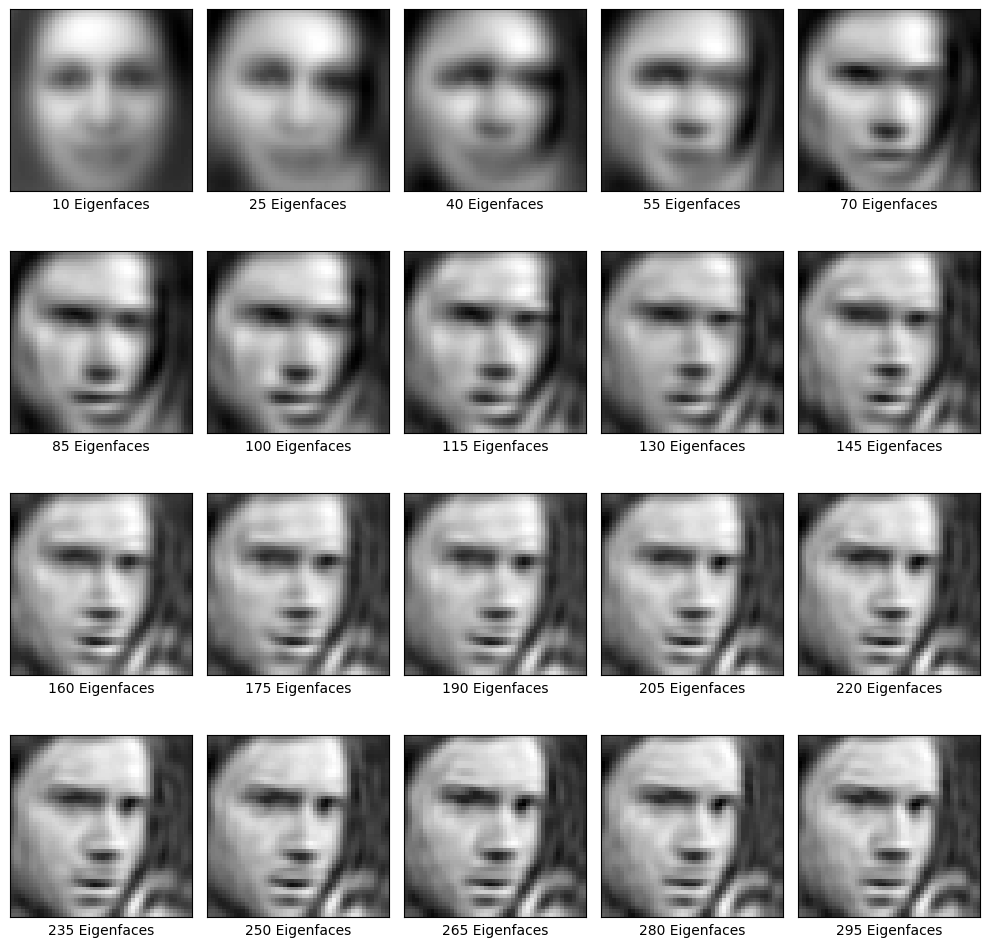

In [ ]:
viz_eigenfaces()

10 Eigenvectors are obviously not sufficient for a good image reconstruction, 150 Eigenvectors may already be sufficient to encode important facial features. A good reconstruction with approximately 300 Eigenvectors for FER2013 Dataset

-----------------------
Draw cumulative explained variance of PCA

In [ ]:
## determine the optimal number of PCs here
## pca.explained_variance_()

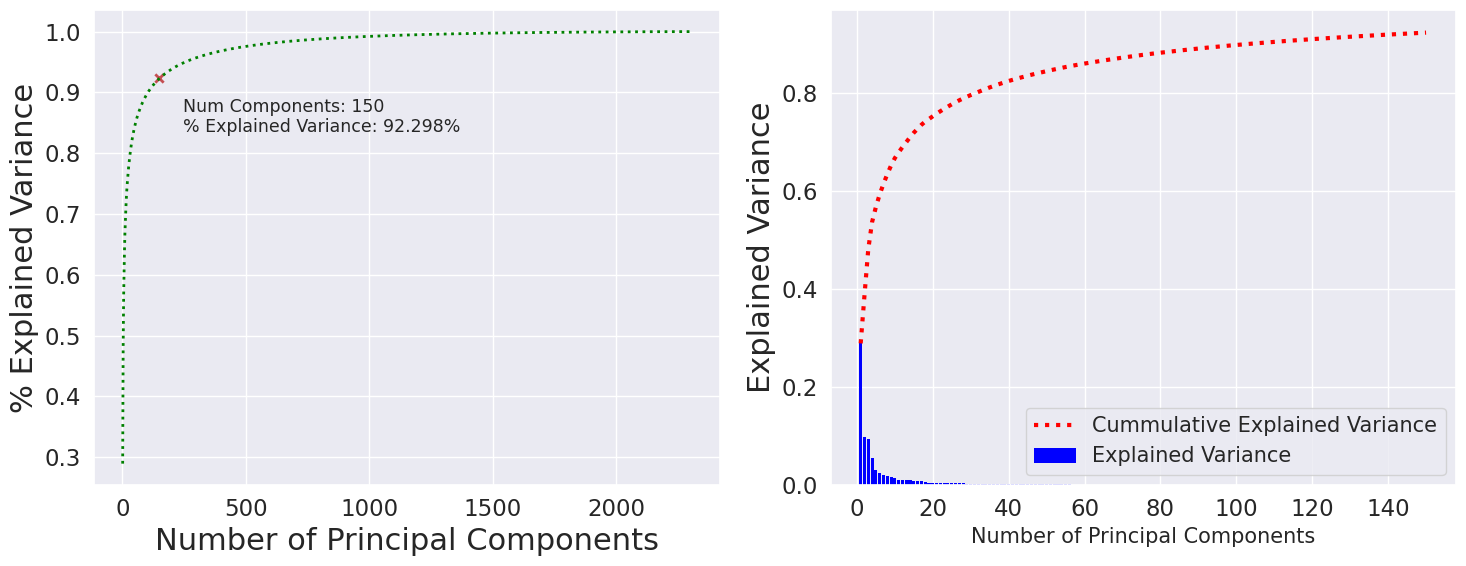

In [ ]:
N_pca_comps = 48 * 48

sns.set(font_scale = 1.5)
figure = plt.figure(figsize = (15, 6))

plt.subplot(121)
plt.plot(range(1, len(cum_vars) + 1), cum_vars, c='green', linewidth = 2, linestyle = "dotted")
plt.scatter(x=[150], y=[cum_vars[149]], linewidth=2, marker='x', color='r')
plt.text(
    s = f"""
    Num Components: 150
    % Explained Variance: {cum_vars[149] * 100:.3f}%
    """,
    x = 155,
    y = 0.8,
    fontsize = "x-small"
)

plt.xlabel('Number of Principal Components', fontsize = 22)
plt.ylabel('% Explained Variance', fontsize = 22)

## determine the optimal number of PCA here
pca_final = PCA(n_components = 150).fit(image_data)

##pca.explained_variance_
explained_ratio = pca_final.explained_variance_ratio_

plt.subplot(122)
plt.bar(
    range(1, len(explained_ratio) + 1),
    explained_ratio,
    color = 'blue',
    linewidth = 0,
)
plt.plot(range(1, 151), cum_vars[:150], linewidth = 3, c = 'red', linestyle = "dotted")
plt.xlabel('Number of Principal Components', fontsize = 15)
plt.ylabel('Explained Variance', fontsize = 22)
plt.gca().legend(('Cummulative Explained Variance',
                  'Explained Variance'), fontsize = 15)

figure.tight_layout()
plt.show();

We see that when choosing the number of eigenfaces/components as $150$, the face is reconstructed quite completely and the percentage of cummulative explained variance is over 90%. This helps us solve the **Curse of Dimensionality**, helps retain the most important information, and helps train the model faster and more effectively.

## 3 . Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

## 3.1 Preprocessing Data

### Preprocessing data for training with Original data

Identify and count the number of images in a dataset where the image has only the same pixel value

In [ ]:
# splitting each string of pixel values and converting to array
pixels = df['pixels'].apply(lambda x: np.fromstring(x, dtype=int, sep=' '))

# creating function to find images with only 1 unique pixel value -- if it's only 1 unique pixel value then the image is just one color
def same_pixel_value(row):
    return np.unique(row).size == 1

# retriving rows
same_pixel_mask = pixels.apply(same_pixel_value)
same_pixel_true_indices = same_pixel_mask[same_pixel_mask==True].index
num_of_images = len(same_pixel_true_indices)

# displaying number of images
print(f"Number of Images with Only One Color: {num_of_images}")

Number of Images with Only One Color: 12


Dropping images with only one color

In [ ]:
# dropping images with only one color
df = df.drop(same_pixel_true_indices)

# displaying new train shape
print(f"New Data Shape: {df.shape}")

New Data Shape: (35875, 2)


In [ ]:
## splitting data into train/val/test subsets here
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=.2, random_state=123)

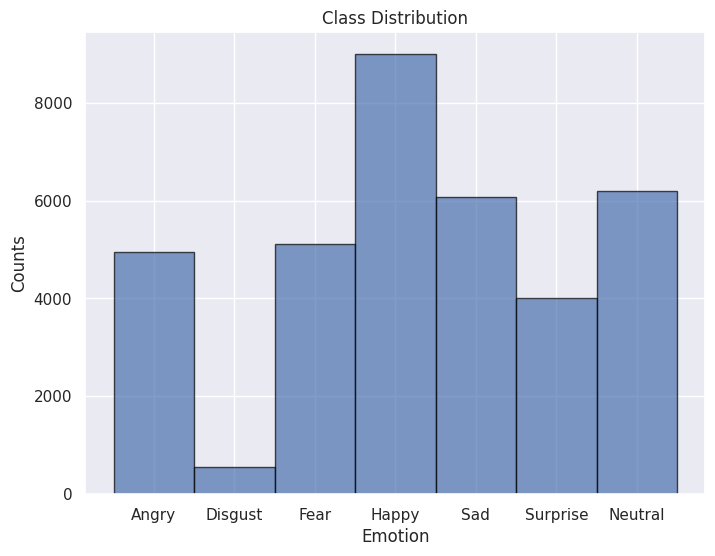

In [ ]:
label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(8, 6))
plt.hist(labels, bins=np.arange(labels.min(), labels.max() + 2) - 0.5, edgecolor='black', alpha=0.7)
plt.title('Class Distribution')
plt.xlabel('Emotion')
plt.ylabel('Counts')
plt.xticks(ticks=range(len(label_names)), labels=label_names, rotation=0);

 Data augmentation

In [ ]:
# Identify minority classes
minority_classes = [0, 1, 2, 4, 5, 6]

# Separate images by class
class_images = {emotion: [] for emotion in minority_classes}
for i, label in enumerate(y_train):
    if label in minority_classes:
        class_images[label].append(X_train[i])

# Data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Augment images and append to original train_images on train dataset

In [ ]:
# Augment images and append to original train_images
augmented_images = []
augmented_labels = []
for emotion, images in class_images.items():
    if len(images) > 0:
        for img in images:
            img = np.expand_dims(img, axis=0)  # Add batch dimension
            img = np.expand_dims(img, axis=-1)  # Add channel dimension (grayscale to 3 channels)
            augment_iter = datagen.flow(img, batch_size=1)
            aug_img = next(augment_iter)[0]
            if emotion == 1:  # Check if the emotion is "Disgust" (assuming 1 is the label for "Disgust")
                # Augment the "Disgust" class 10 times
                for _ in range(10):
                    augmented_images.append(aug_img)
                    augmented_labels.append(emotion)  # Update labels accordingly
            else:
                # For other minority classes, augment only once
                augmented_images.append(aug_img)
                augmented_labels.append(emotion)  # Update labels accordingly

# Convert augmented_images and augmented_labels to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Check the shape of the augmented images and labels
print("Augmented Images Shape:", augmented_images.shape)
print("Augmented Labels Shape:", augmented_labels.shape)

Augmented Images Shape: (25446, 48, 48, 1)
Augmented Labels Shape: (25446,)


In [ ]:
augmented_images = np.squeeze(augmented_images, axis=-1)
# Check the shape of the augmented images and labels
print("Train Images Shape:", X_train.shape)
print("Train Labels Shape:", y_train.shape)
# Concatenate augmented images with original images
X_train_augmented = np.concatenate((X_train, augmented_images), axis=0)
y_train_augmented = np.concatenate((y_train, augmented_labels), axis=0)

# Check the shape of the augmented train data
print("Augmented Train Images Shape:", X_train_augmented.shape)
print("Augmented Train Labels Shape:", y_train_augmented.shape)

Train Images Shape: (28700, 48, 48)
Train Labels Shape: (28700,)
Augmented Train Images Shape: (54146, 48, 48)
Augmented Train Labels Shape: (54146,)


Compute class weight

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights for augmented data
unique_classes_augmented = np.unique(y_train_augmented)
class_counts_augmented = y_train_augmented.tolist()
class_weights_augmented = compute_class_weight(class_weight="balanced", classes=unique_classes_augmented, y=class_counts_augmented)
class_weights_dict_augmented = dict(zip(unique_classes_augmented, class_weights_augmented))

# Print class weights for augmented data
print("Class Weights Dictionary for Augmented Data:")
for key, value in class_weights_dict_augmented.items():
    print(f"Class {key}: {value}")


Class Weights Dictionary for Augmented Data:
Class 0: 0.9773999061337955
Class 1: 1.5909384732914145
Class 2: 0.9456164862032833
Class 3: 1.0695717446270543
Class 4: 0.8042361049223182
Class 5: 1.207107187444266
Class 6: 0.7788101950405615


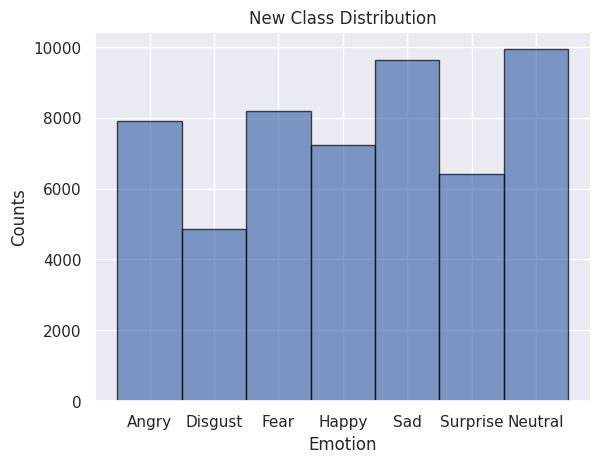

In [ ]:
unique_classes, class_counts = np.unique(y_train_augmented, return_counts=True)

plt.hist(y_train_augmented, bins=np.arange(unique_classes.min(), unique_classes.max() + 2) - 0.5, edgecolor='black', alpha=0.7)
plt.title('New Class Distribution')
plt.xlabel('Emotion')
plt.ylabel('Counts')
plt.xticks(ticks=range(len(label_names)), labels=label_names, rotation=0)
plt.show()

In [ ]:
label_counts = np.bincount(y_train_augmented)
print("Class Counts in Augmented Data:")
for label, count in enumerate(label_counts):
    print(f"Class {label}: {count} samples")

Class Counts in Augmented Data:
Class 0: 7914 samples
Class 1: 4862 samples
Class 2: 8180 samples
Class 3: 7232 samples
Class 4: 9618 samples
Class 5: 6408 samples
Class 6: 9932 samples


In [ ]:
from skimage.feature import hog
from tqdm import tqdm
# Function to preprocess images using HOG with support for grayscale and color/multichannel images
def preprocess_with_hog(images):
    hog_features = []
    hog_images = []
    for image in tqdm(images):
        # Calculate HOG features and visualize HOG image
        features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
        cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys',  visualize=True)
        hog_features.append(features)
        hog_images.append(hog_image)
    hog_features = np.array(hog_features)
    return hog_features, hog_images

In [ ]:
hog_features, hog_images = preprocess_with_hog(X_train_augmented)

100%|██████████| 54146/54146 [05:59<00:00, 150.71it/s]


In [ ]:
Xtest, _ = preprocess_with_hog(X_test)

100%|██████████| 7175/7175 [00:51<00:00, 139.57it/s]


### Preprocessing data for training with PCA

In [ ]:
n_sample, height,weight= images.shape
X=images.reshape(n_sample, height*weight)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight


unique_classes = np.unique(df['emotion'])
class_counts = df['emotion'].to_list()
class_weights = compute_class_weight(class_weight="balanced", classes=unique_classes, y=class_counts)
class_weights_dict = dict(zip(unique_classes, class_weights))
# printing class weights
print("Class Weights Dictionary:")
for key, value in class_weights_dict.items():
    print(f"Class {key}: {value}")

Class Weights Dictionary:
Class 0: 1.0364004044489383
Class 1: 9.36928702010969
Class 2: 1.0007810974419058
Class 3: 0.5702047174009791
Class 4: 0.8434825543120474
Class 5: 1.2809297675581104
Class 6: 0.8270130708407294


## 3.2 Original data

In [ ]:
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


import warnings
warnings.filterwarnings("ignore")


def calculate_performance(y_true, y_pred):
    print("_" * 80)
    print("| Accuracy: ", accuracy_score(y_true, y_pred))
    print("| Precision (weighted): ", precision_score(y_true, y_pred, average='weighted'))
    print("| Recall (weighted): ", recall_score(y_true, y_pred, average='weighted'))
    print("| F1 Score (weighted): ", f1_score(y_true, y_pred, average='weighted'))
    print("_" * 80)
    print("| Precision (macro): ", precision_score(y_true, y_pred, average='macro'))
    print("| Recall (macro): ", recall_score(y_true, y_pred, average='macro'))
    print("| F1 Score (macro): ", f1_score(y_true, y_pred, average='macro'))
    print("_" * 80)
    print("| Precision (micro): ", precision_score(y_true, y_pred, average='micro'))
    print("| Recall (micro): ", recall_score(y_true, y_pred, average='micro'))
    print("| F1 Score (micro): ", f1_score(y_true, y_pred, average='micro'))
    print("_" * 80)


### Logistic Regression

In [ ]:
#! pip install -q optuna

In [ ]:
from cuml.linear_model import LogisticRegression as cuLogisticRegression
import cupy as cp

X_train = cp.asarray(hog_features)
y_train = cp.asarray(y_train_augmented)

In [ ]:
def objective(trial):
    params = {
        'penalty': trial.suggest_categorical("penalty", ['none', 'l1', 'l2', 'elasticnet' ]),
        'C': trial.suggest_float("C", 1, 1e5),
        'l1_ratio': trial.suggest_float('l1_ratio', 0, 1)
    }

    model = cuLogisticRegression(
        class_weight = 'balanced',
        max_iter = 3000,
        **params
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(Xtest)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(
    objective,
    n_trials = 10,
    n_jobs = -1
)

[I 2024-06-21 01:01:54,179] A new study created in memory with name: no-name-59d32baa-5929-45fa-a44a-b0fedb67d857
[I 2024-06-21 01:03:31,991] Trial 1 finished with value: 0.42174216027874567 and parameters: {'penalty': 'none', 'C': 55580.33726925509, 'l1_ratio': 0.49288096034333184}. Best is trial 1 with value: 0.42174216027874567.
[I 2024-06-21 01:04:15,722] Trial 0 finished with value: 0.42174216027874567 and parameters: {'penalty': 'none', 'C': 6054.982536016692, 'l1_ratio': 0.6350564182041606}. Best is trial 1 with value: 0.42174216027874567.
[I 2024-06-21 01:04:15,749] Trial 2 finished with value: 0.42090592334494775 and parameters: {'penalty': 'none', 'C': 30174.382410742826, 'l1_ratio': 0.8366825063462301}. Best is trial 1 with value: 0.42174216027874567.


[W] [01:07:15.478752] QWL-QN: max iterations reached
[W] [01:07:15.481503] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


[I 2024-06-21 01:11:01,819] Trial 3 finished with value: 0.42634146341463414 and parameters: {'penalty': 'l1', 'C': 72922.09510679111, 'l1_ratio': 0.06658188909280416}. Best is trial 3 with value: 0.42634146341463414.
[I 2024-06-21 01:11:01,844] Trial 4 finished with value: 0.4259233449477352 and parameters: {'penalty': 'elasticnet', 'C': 82295.40337536702, 'l1_ratio': 0.7930277011881105}. Best is trial 3 with value: 0.42634146341463414.
[I 2024-06-21 01:15:19,167] Trial 5 finished with value: 0.42048780487804877 and parameters: {'penalty': 'none', 'C': 57566.62841627605, 'l1_ratio': 0.8060575452783011}. Best is trial 3 with value: 0.42634146341463414.
[I 2024-06-21 01:15:19,194] Trial 6 finished with value: 0.42564459930313586 and parameters: {'penalty': 'l1', 'C': 66827.82861409495, 'l1_ratio': 0.5489654192962532}. Best is trial 3 with value: 0.42634146341463414.


[W] [01:15:19.137400] QWL-QN: max iterations reached
[W] [01:15:19.149407] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


[I 2024-06-21 01:18:55,655] Trial 7 finished with value: 0.4264808362369338 and parameters: {'penalty': 'elasticnet', 'C': 59916.762569747894, 'l1_ratio': 0.9439514730311714}. Best is trial 7 with value: 0.4264808362369338.


[W] [01:18:55.614468] QWL-QN: max iterations reached
[W] [01:18:55.617467] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


[I 2024-06-21 01:22:58,740] Trial 8 finished with value: 0.42090592334494775 and parameters: {'penalty': 'none', 'C': 79631.69319990234, 'l1_ratio': 0.8990783529004241}. Best is trial 7 with value: 0.4264808362369338.
[I 2024-06-21 01:22:58,758] Trial 9 finished with value: 0.42578397212543556 and parameters: {'penalty': 'l1', 'C': 16353.619460954522, 'l1_ratio': 0.3298146877009386}. Best is trial 7 with value: 0.4264808362369338.


[W] [01:22:58.708127] QWL-QN: max iterations reached
[W] [01:22:58.719980] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


In [ ]:
print("Best hyperparameters: ", study.best_params)
print("Best accuracy: {:.2f}".format(study.best_value))

Best hyperparameters:  {'penalty': 'elasticnet', 'C': 59916.762569747894, 'l1_ratio': 0.9439514730311714}
Best accuracy: 0.43


In [ ]:
model = cuLogisticRegression()

param_grid = {
    'penalty': ['l2', 'elasticnet'],
    'C': [1e5, 1e6],
    'l1_ratio': [0.7, 0.8]
}

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=3,
    n_jobs=-1
)

grid_search.fit(hog_features, y_train_augmented)

In [ ]:
y_pred = grid_search.predict(Xtest)

In [ ]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.25      0.29       988
           1       0.16      0.26      0.20       105
           2       0.31      0.20      0.24      1031
           3       0.56      0.65      0.60      1756
           4       0.32      0.29      0.30      1267
           5       0.48      0.52      0.50       797
           6       0.37      0.48      0.42      1231

    accuracy                           0.42      7175
   macro avg       0.36      0.38      0.36      7175
weighted avg       0.40      0.42      0.41      7175

[[ 248   35   81  167  170   72  215]
 [  18   27   13   11   13    5   18]
 [ 102   25  202  167  171  175  189]
 [ 119   30   78 1139  158   68  164]
 [ 134   28  113  236  362   74  320]
 [  40   11   74  101   50  416  105]
 [  86   13   85  198  190   65  594]]


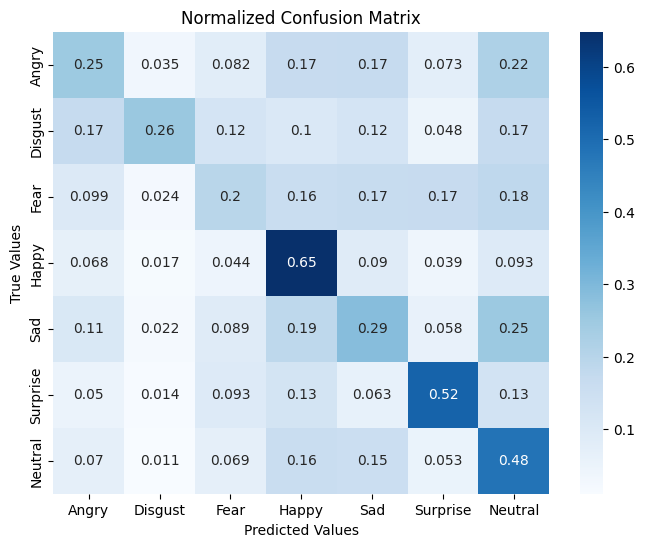

              precision    recall  f1-score   support

       Angry       0.33      0.25      0.29       988
     Disgust       0.16      0.26      0.20       105
        Fear       0.31      0.20      0.24      1031
       Happy       0.56      0.65      0.60      1756
         Sad       0.32      0.29      0.30      1267
    Surprise       0.48      0.52      0.50       797
     Neutral       0.37      0.48      0.42      1231

    accuracy                           0.42      7175
   macro avg       0.36      0.38      0.36      7175
weighted avg       0.40      0.42      0.41      7175



In [ ]:
# creating confusion matrix
public_cm = confusion_matrix(y_test, y_pred, normalize='true')

# plotting normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(public_cm, cmap='Blues', annot=True, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Normalized Confusion Matrix')
plt.show()

# creating classification report
public_cr = classification_report(y_test, y_pred, target_names=label_names)
print(public_cr)

### DecisionTreeClassifier

In [ ]:
import optuna

from sklearn.tree import DecisionTreeClassifier



def objective(trial):
    # Define the hyperparameters to tune
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])

    # Create and train the model
    model = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=class_weights_dict_augmented,
        random_state=42
    )

    model.fit(hog_features, y_train_augmented)

    # Evaluate the model
    y_pred = model.predict(Xtest)


    acc = accuracy_score(y_test, y_pred)

    return acc


# Create the study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-06-20 09:24:47,691] A new study created in memory with name: no-name-09c4d354-a344-4ad4-8d4c-e126de261260
[I 2024-06-20 09:25:04,095] Trial 0 finished with value: 0.2843205574912892 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.2843205574912892.
[I 2024-06-20 09:25:05,409] Trial 1 finished with value: 0.2221602787456446 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.2843205574912892.
[I 2024-06-20 09:26:54,285] Trial 2 finished with value: 0.2840418118466899 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 0 with value: 0.2843205574912892.
[I 2024-06-20 09:26:54,777] Trial 3 finished with value: 0.2631358885

In [ ]:
from sklearn.tree import DecisionTreeClassifier
def build_model(X, y):
    """
    Design your model and train it (including your best params)
    :param X: feature matrix
    :param y: target
    :return: a model
    """

    # Todo: Input your scaler and logistic model into pipeline
    model = DecisionTreeClassifier(class_weight=class_weights_dict_augmented)

    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [30, 32 ],
        'splitter': ['best', 'random']
    }


    # Todo: fit your model with X, y
    grid_search = GridSearchCV(model, param_grid, cv=4)
    grid_search.fit(X,y)

    return grid_search

In [ ]:
model=build_model(hog_features, y_train_augmented)

In [ ]:
model.best_params_

{'criterion': 'gini', 'max_depth': 32, 'splitter': 'best'}

In [ ]:
best_model = model.best_estimator_

In [ ]:
best_model

DecisionTreeClassifier(class_weight={0: 0.9773999061337955,
                                     1: 1.5909384732914145,
                                     2: 0.9456164862032833,
                                     3: 1.0695717446270543,
                                     4: 0.8042361049223182,
                                     5: 1.207107187444266,
                                     6: 0.7788101950405615},
                       max_depth=32)

In [ ]:
pred=best_model.predict(Xtest)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.21      0.23      0.22       988
           1       0.24      0.30      0.26       105
           2       0.25      0.26      0.25      1031
           3       0.48      0.36      0.41      1756
           4       0.26      0.25      0.26      1267
           5       0.38      0.44      0.41       797
           6       0.26      0.29      0.28      1231

    accuracy                           0.31      7175
   macro avg       0.30      0.31      0.30      7175
weighted avg       0.32      0.31      0.31      7175



In [ ]:
print(confusion_matrix(y_test, pred))

[[231  20 159 124 180  88 186]
 [ 11  31  15   9  14   7  18]
 [144  15 271 135 164 118 184]
 [232  24 197 631 250 145 277]
 [197  16 200 171 320 113 250]
 [ 76   7  89  89  86 352  98]
 [213  16 164 159 213 108 358]]


### RandomForestClassifier

In [ ]:
import optuna

from sklearn.ensemble import RandomForestClassifier

def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 10, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])


    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        class_weight=class_weights_dict_augmented,
        random_state=42
    )


    model.fit(hog_features, y_train_augmented)

    y_pred = model.predict(Xtest)

    acc = accuracy_score(y_test, y_pred)

    return acc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best hyperparameters: ", study.best_params)
print("Best accuracy: {:.2f}".format(study.best_value))

[I 2024-06-18 04:57:04,231] A new study created in memory with name: no-name-88ec1faf-b746-4383-8308-f82bff9e5ffa
[I 2024-06-18 05:00:39,855] Trial 0 finished with value: 0.35851322702957744 and parameters: {'n_estimators': 134, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 0 with value: 0.35851322702957744.
[I 2024-06-18 05:11:16,766] Trial 1 finished with value: 0.4670838089102526 and parameters: {'n_estimators': 280, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 1 with value: 0.4670838089102526.
[I 2024-06-18 05:27:37,969] Trial 2 finished with value: 0.49748842772718993 and parameters: {'n_estimators': 229, 'max_depth': 29, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 2 with value: 0.49748842772718993.
[I 2024-06-18 05:29:57,011] Trial 3 finished with value: 0.4854588707081

Best hyperparameters:  {'n_estimators': 261, 'max_depth': 32, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False}
Best accuracy: 0.51


In [ ]:

from cuml.ensemble import cuRandomForestClassifier
param_grid = {
    'n_estimators': [250, 300],
    'max_depth': [16, 32],
}

model = cuRandomForestClassifier(
    max_features = 1.0,
    bootstrap = True
)

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=3,
    n_jobs=-1
)

grid_search.fit(hog_features, y_train_augmented)

In [ ]:
grid_search

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [16, 32], 'n_estimators': [250, 300]})

In [ ]:
y_pred = grid_search.predict(Xtest)

In [ ]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.24      0.32       988
           1       1.00      0.27      0.42       105
           2       0.46      0.28      0.35      1031
           3       0.66      0.61      0.63      1756
           4       0.32      0.44      0.37      1267
           5       0.68      0.55      0.61       797
           6       0.36      0.61      0.45      1231

    accuracy                           0.47      7175
   macro avg       0.57      0.43      0.45      7175
weighted avg       0.51      0.47      0.47      7175

[[ 234    0   76  106  257   31  284]
 [  13   28   13   11   19    2   19]
 [  55    0  285  109  246   89  247]
 [  38    0   62 1071  294   32  259]
 [  67    0   71  156  554   24  395]
 [  15    0   57   61   86  440  138]
 [  31    0   50  119  256   27  748]]


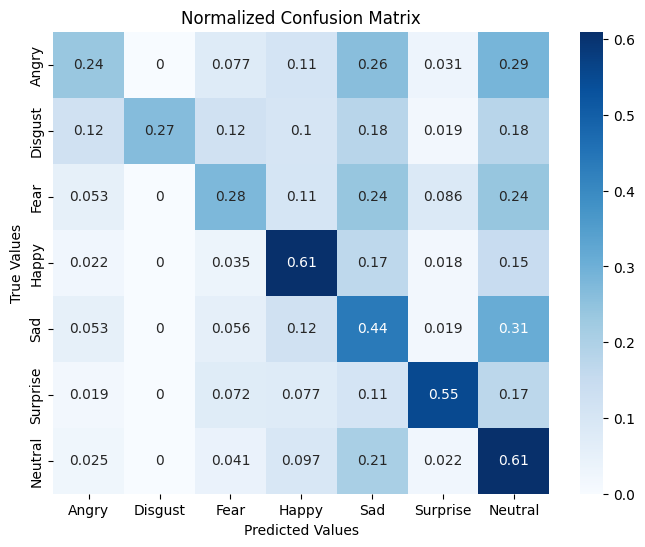

              precision    recall  f1-score   support

       Angry       0.52      0.24      0.32       988
     Disgust       1.00      0.27      0.42       105
        Fear       0.46      0.28      0.35      1031
       Happy       0.66      0.61      0.63      1756
         Sad       0.32      0.44      0.37      1267
    Surprise       0.68      0.55      0.61       797
     Neutral       0.36      0.61      0.45      1231

    accuracy                           0.47      7175
   macro avg       0.57      0.43      0.45      7175
weighted avg       0.51      0.47      0.47      7175



In [ ]:
# creating confusion matrix
public_cm = confusion_matrix(y_test, y_pred, normalize='true')

# plotting normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(public_cm, cmap='Blues', annot=True, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Normalized Confusion Matrix')
plt.show()

# creating classification report
public_cr = classification_report(y_test, y_pred, target_names=label_names)
print(public_cr)

### SVM

In [ ]:
from cuml.svm import SVC as cuSVC
from sklearn.model_selection import GridSearchCV

In [ ]:
model = cuSVC()

param_grid = {
    'C': [0.1, 10],
    'kernel': ['poly', 'rbf'],
    'degree': [6],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=2,
    n_jobs=-1
)

grid_search.fit(hog_features, y_train_augmented)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=2, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 10], 'class_weight': ['balanced'],
                         'degree': [6], 'kernel': ['poly', 'rbf']})

In [ ]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(Xtest)

In [ ]:
best_model

SVC()

In [ ]:
grid_search.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'degree': 6, 'kernel': 'poly'}

In [ ]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.43      0.45       988
           1       0.87      0.51      0.65       105
           2       0.46      0.42      0.44      1031
           3       0.73      0.73      0.73      1756
           4       0.45      0.46      0.45      1267
           5       0.72      0.69      0.70       797
           6       0.48      0.56      0.52      1231

    accuracy                           0.56      7175
   macro avg       0.60      0.54      0.56      7175
weighted avg       0.56      0.56      0.56      7175

[[ 429    4  101  103  175   33  143]
 [  21   54    7    4   14    1    4]
 [  95    3  435   75  186  100  137]
 [  91    0   71 1275  128   38  153]
 [ 128    0  167  121  586   22  243]
 [  35    1   76   46   27  552   60]
 [ 100    0   85  134  199   25  688]]


### MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
def objective(trial):

    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes',
                                                   [ (512, 128, 64),
                                                    (512, 64,7), (1024,512 , 128), (1024, 512, 128,7)])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd', 'lbfgs'])
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])


    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation,
                          solver=solver, alpha=alpha, learning_rate=learning_rate,
                          max_iter=200, random_state=42)

    model.fit(hog_features, y_train_augmented)

    # Evaluate the model
    y_pred = model.predict(Xtest)

    acc = accuracy_score(y_test, y_pred)

    return acc


# Create the study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=4)

[I 2024-06-18 07:16:01,215] A new study created in memory with name: no-name-df6ecf83-f291-4e97-a465-a19900aef2b8
[I 2024-06-18 08:12:10,409] Trial 0 finished with value: 0.4339501457211281 and parameters: {'hidden_layer_sizes': (1024, 512, 128), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.000509273492867657, 'learning_rate': 'constant'}. Best is trial 0 with value: 0.4339501457211281.
[I 2024-06-18 09:08:09,321] Trial 1 finished with value: 0.41084743789453154 and parameters: {'hidden_layer_sizes': (1024, 512, 128, 7), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.06919742152090592, 'learning_rate': 'constant'}. Best is trial 0 with value: 0.4339501457211281.
[I 2024-06-18 09:25:21,790] Trial 2 finished with value: 0.029435559494470007 and parameters: {'hidden_layer_sizes': (1024, 512, 128), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.056245845991147805, 'learning_rate': 'adaptive'}. Best is trial 0 with value: 0.4339501457211281.
[I 2024-06-18 09:59:32,767] T

In [ ]:

best_model = MLPClassifier(hidden_layer_sizes= (512, 64, 7), activation= 'logistic', solver= 'adam', alpha= 2.980758764255605e-05, learning_rate= 'constant', random_state=42)
best_model.fit(hog_features, y_train_augmented)

MLPClassifier(activation='logistic', alpha=2.980758764255605e-05,
              hidden_layer_sizes=(512, 64, 7), random_state=42)

In [ ]:
pred=best_model.predict(Xtest)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.36      0.38      0.37       988
           1       0.54      0.52      0.53       105
           2       0.34      0.40      0.37      1031
           3       0.72      0.62      0.67      1756
           4       0.40      0.40      0.40      1267
           5       0.61      0.63      0.62       797
           6       0.42      0.41      0.41      1231

    accuracy                           0.48      7175
   macro avg       0.48      0.48      0.48      7175
weighted avg       0.49      0.48      0.49      7175



### XGBoost Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score


def objective(trial):
    params = {
        "device": "cuda",
        "objective": trial.suggest_categorical("objective", ["multi:softmax", "multi:softprob", "ovr"]),
        "n_estimators": 150,
        "gamma": trial.suggest_float("gamma", 0, 10),
        "verbosity": 1,
        "eta": trial.suggest_float("eta", 0, 1),
        "alpha": trial.suggest_float("alpha", 0, 10),
        "lambda": trial.suggest_float("lambda", 0, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.5, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
   }

    model = xgb.XGBClassifier(**params)
    model.fit(hog_features, y_train_augmented, verbose = False)
    y_pred = model.predict(Xtest)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [ ]:
%%time
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, n_jobs = -1)

[I 2024-06-20 10:53:14,322] A new study created in memory with name: no-name-67c8ded1-4aa0-4dec-8453-a7d90cd36a6d
[10:54:10] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

[I 2024-06-20 10:54:10,753] Trial 2 finished with value: 0.39484320557491287 and parameters: {'objective': 'ovr', 'gamma': 0.4410059843832048, 'eta': 0.8166586323421084, 'alpha': 6.173021313463941, 'lambda': 7.560622680686416, 'learning_rate': 0.14194646557285676, 'max_depth': 1, 'subsample': 0.583646847986787, 'colsample_bytree': 0.3625351310264961, 'min_child_weight': 16}. Best is trial 2 with value: 0.39484320557491287.
[I 2024-06-2

CPU times: user 44min 42s, sys: 39.6 s, total: 45min 22s
Wall time: 15min 54s


In [ ]:
model = xgb.XGBClassifier(**study.best_params)
model.fit(hog_features, y_train_augmented)
y_pred = model.predict(Xtest)

In [ ]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.32      0.36       988
           1       0.83      0.14      0.24       105
           2       0.38      0.25      0.30      1031
           3       0.64      0.69      0.66      1756
           4       0.37      0.38      0.38      1267
           5       0.61      0.60      0.60       797
           6       0.41      0.57      0.48      1231

    accuracy                           0.48      7175
   macro avg       0.52      0.42      0.43      7175
weighted avg       0.48      0.48      0.47      7175

[[ 313    1   88  126  188   52  220]
 [  21   15   10   18   18    6   17]
 [ 102    0  253  133  213  133  197]
 [ 101    1   64 1205  185   44  156]
 [ 121    1  116  181  487   34  327]
 [  36    0   69   68   46  476  102]
 [  70    0   69  157  193   41  701]]


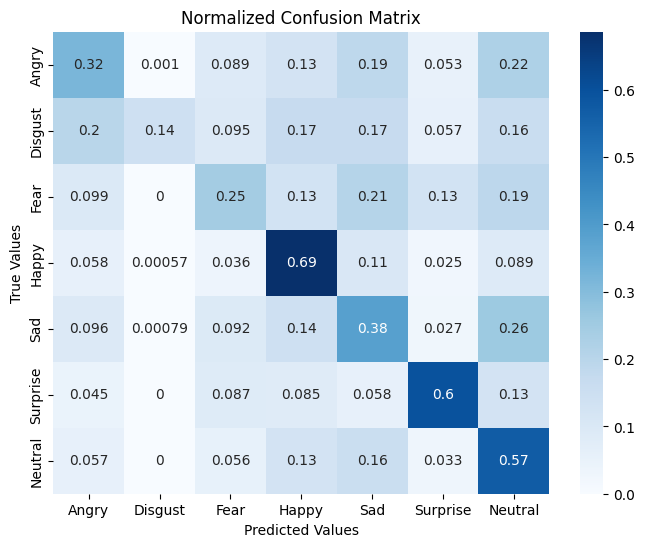

              precision    recall  f1-score   support

       Angry       0.41      0.32      0.36       988
     Disgust       0.83      0.14      0.24       105
        Fear       0.38      0.25      0.30      1031
       Happy       0.64      0.69      0.66      1756
         Sad       0.37      0.38      0.38      1267
    Surprise       0.61      0.60      0.60       797
     Neutral       0.41      0.57      0.48      1231

    accuracy                           0.48      7175
   macro avg       0.52      0.42      0.43      7175
weighted avg       0.48      0.48      0.47      7175



In [ ]:
# creating confusion matrix
public_cm = confusion_matrix(y_test, y_pred, normalize='true')

# plotting normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(public_cm, cmap='Blues', annot=True, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Normalized Confusion Matrix')
plt.show()

# creating classification report
public_cr = classification_report(y_test, y_pred, target_names=label_names)
print(public_cr)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best Accuracy:', study.best_value)

Best hyperparameters: {'objective': 'ovr', 'gamma': 3.841930225517077, 'eta': 0.9970515251272614, 'alpha': 3.846498805915674, 'lambda': 4.011220244008975, 'learning_rate': 0.10999156549880784, 'max_depth': 8, 'subsample': 0.7975068021500443, 'colsample_bytree': 0.29269562823005035, 'min_child_weight': 5}
Best Accuracy: 0.49142857142857144


## 3.3 Transformed data

In [ ]:
RANDOM_STATE = 42
TRAIN_SIZE = 0.8
trainX, testX ,trainY, testY = train_test_split(X, labels, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

### LogisticRegression

In [ ]:
from cuml.linear_model import LogisticRegression as culr

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA



def objective(trial):
    params = {
        'penalty': trial.suggest_categorical("penalty", ['none', 'l1', 'l2', 'elasticnet' ]),
        'C': trial.suggest_float("C", 1, 1e5),
        'l1_ratio': trial.suggest_float('l1_ratio', 0, 1)
    }

    model=make_pipeline(StandardScaler(), PCA(150),culr(
        class_weight = 'balanced',
        max_iter = 3000,
        **params
    ))


    model.fit(trainX, trainY)
    y_pred = model.predict(testX)

    accuracy = accuracy_score(testY, y_pred)
    return accuracy



In [ ]:

# Create a study object and specify the direction to maximize the score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, n_jobs=-1)

[I 2024-06-21 02:21:24,936] A new study created in memory with name: no-name-4e88d048-74c9-4f43-9150-bc7d48427ca9
[I 2024-06-21 02:27:43,878] Trial 2 finished with value: 0.37419894337654114 and parameters: {'penalty': 'elasticnet', 'C': 25367.71277717451, 'l1_ratio': 0.21089073913961975}. Best is trial 2 with value: 0.37419894337654114.
[I 2024-06-21 02:27:44,057] Trial 0 finished with value: 0.37405961751937866 and parameters: {'penalty': 'elasticnet', 'C': 48410.43849623039, 'l1_ratio': 0.9492457836195581}. Best is trial 2 with value: 0.37419894337654114.
[I 2024-06-21 02:27:44,419] Trial 1 finished with value: 0.37350237369537354 and parameters: {'penalty': 'l1', 'C': 20817.21236350115, 'l1_ratio': 0.22220364642604218}. Best is trial 2 with value: 0.37419894337654114.
[I 2024-06-21 02:27:44,737] Trial 3 finished with value: 0.3715519607067108 and parameters: {'penalty': 'l1', 'C': 39297.80362963332, 'l1_ratio': 0.6098857751874989}. Best is trial 2 with value: 0.37419894337654114.
[

In [ ]:
study.best_params

{'penalty': 'elasticnet',
 'C': 70220.61374729182,
 'l1_ratio': 0.9014757350590278}

In [ ]:
def build_model(X, y):
    """
    Design your model and train it (including your best params)
    :param X: feature matrix
    :param y: target
    :return: a model
    """

    # Todo: Input your scaler and logistic model into pipeline
    model = make_pipeline(StandardScaler(),
                          PCA(n_components=150),
                          culr()
                         )

    param_grid = {
    'logisticregression__penalty': ['l2', 'elasticnet'],
    'logisticregression__C': [70220, 80000],
    'logisticregression__l1_ratio': [0.9, 0.8]
    }



    # Todo: fit your model with X, y
    grid_search = GridSearchCV(model, param_grid, cv=4, n_jobs=-1)
    grid_search.fit(X,y)

    return grid_search

In [ ]:
model= build_model(trainX, trainY)

In [ ]:
model.best_params_

{'logisticregression__C': 70220,
 'logisticregression__l1_ratio': 0.8,
 'logisticregression__penalty': 'elasticnet'}

In [ ]:
best_model = model.best_estimator_
best_model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=150)),
                ('logisticregression', LogisticRegression())])

In [ ]:
from sklearn.metrics import confusion_matrix
pred=best_model.predict(testX)
print(classification_report(testY, pred))
print(confusion_matrix(testY, pred))

              precision    recall  f1-score   support

           0       0.30      0.16      0.21       985
           1       0.50      0.04      0.07       102
           2       0.25      0.12      0.16      1043
           3       0.42      0.70      0.53      1765
           4       0.29      0.30      0.30      1210
           5       0.47      0.47      0.47       795
           6       0.36      0.32      0.34      1278

    accuracy                           0.37      7178
   macro avg       0.37      0.30      0.30      7178
weighted avg       0.35      0.37      0.35      7178

[[ 160    1   89  335  187   69  144]
 [  12    4   20   31   16    6   13]
 [ 100    1  129  347  177  133  156]
 [  74    0   64 1239  198   71  119]
 [  96    1   87  373  362   67  224]
 [  28    1   73  171   68  374   80]
 [  68    0   63  423  235   81  408]]


### DescisionTree

In [ ]:
import optuna

In [ ]:
def objective(trial):
    # Define the hyperparameters to tune
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', [1.0, 'sqrt', 'log2'])

    # Create and train the model
    model=make_pipeline(StandardScaler(),
                        PCA(150),
                        DecisionTreeClassifier(
                        criterion=criterion,
                        splitter=splitter,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        max_features=max_features,
                        class_weight=class_weights_dict,
                        random_state=42
    ))


    model.fit(trainX, trainY)

    # Evaluate the model
    y_pred = model.predict(testX)


    acc = accuracy_score(testY, y_pred)

    return acc




In [ ]:
# Create the study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, n_jobs=-1)

[I 2024-06-21 02:48:33,332] A new study created in memory with name: no-name-de9bba1f-590e-4966-97d3-85f766dccc26
[I 2024-06-21 02:49:22,753] Trial 1 finished with value: 0.16306620209059233 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.16306620209059233.
[I 2024-06-21 02:49:23,100] Trial 0 finished with value: 0.12069686411149826 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.16306620209059233.
[I 2024-06-21 02:50:12,258] Trial 2 finished with value: 0.2324738675958188 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 1.0}. Best is trial 2 with value: 0.2324738675958188.
[I 2024-06-21 02:50:18,681] Trial 3 finished with value: 0.26508710

In [ ]:
study.best_params

{'criterion': 'entropy',
 'splitter': 'best',
 'max_depth': 20,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt'}

In [ ]:
from sklearn.tree import DecisionTreeClassifier
def build_model(X, y):
    """
    Design your model and train it (including your best params)
    :param X: feature matrix
    :param y: target
    :return: a model
    """

    # Todo: Input your scaler and logistic model into pipeline
    model = make_pipeline(StandardScaler(),
                          PCA(n_components=150),
                          DecisionTreeClassifier(class_weight=class_weights_dict))

    param_grid = {
        'decisiontreeclassifier__criterion': ['gini', 'entropy'],
        'decisiontreeclassifier__max_depth': [ 20, 30],
        'decisiontreeclassifier__splitter': ['best', 'random'],

    }


    # Todo: fit your model with X, y
    grid_search = GridSearchCV(model, param_grid, cv=4, n_jobs=-1)
    grid_search.fit(X,y)

    return grid_search

In [ ]:
model=build_model(trainX,trainY)

In [ ]:
model.best_params_

{'decisiontreeclassifier__criterion': 'gini',
 'decisiontreeclassifier__max_depth': 30,
 'decisiontreeclassifier__splitter': 'best'}

In [ ]:
best_model = model.best_estimator_
best_model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=150)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight={0: 1.0364004044489383,
                                                      1: 9.36928702010969,
                                                      2: 1.0007810974419058,
                                                      3: 0.5702047174009791,
                                                      4: 0.8434825543120474,
                                                      5: 1.2809297675581104,
                                                      6: 0.8270130708407294},
                                        max_depth=30))])

In [ ]:
from sklearn.metrics import confusion_matrix
pred=best_model.predict(testX)
print(classification_report(testY, pred))
print(confusion_matrix(testY, pred))

              precision    recall  f1-score   support

           0       0.22      0.22      0.22       931
           1       0.21      0.29      0.24       101
           2       0.25      0.26      0.26      1021
           3       0.34      0.33      0.33      1811
           4       0.25      0.24      0.24      1236
           5       0.41      0.45      0.43       822
           6       0.26      0.25      0.26      1253

    accuracy                           0.29      7175
   macro avg       0.28      0.29      0.28      7175
weighted avg       0.29      0.29      0.29      7175

[[206  15 130 212 149  72 147]
 [ 10  29  10  22  14   9   7]
 [109  18 269 214 164  97 150]
 [214  29 256 595 264 158 295]
 [172  18 174 276 294  92 210]
 [ 61   9  81 124  85 370  92]
 [154  18 152 303 196 111 319]]


### RandomForest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from cuml.ensemble import RandomForestClassifier as curfc


def build_model(X, y):
    """
    Design your model and train it (including your best params)
    :param X: feature matrix
    :param y: target
    :return: a model
    """


    model = make_pipeline(StandardScaler(),PCA(150),curfc())

    param_grid = {
        'randomforestclassifier__n_estimators': [200, 250 ],
        'randomforestclassifier__bootstrap': [True, False],
        'randomforestclassifier__max_depth': [26, 28],
    }

    grid_search = GridSearchCV(model, param_grid, cv=4)
    grid_search.fit(X,y)

    return grid_search

In [ ]:
model= build_model(trainX, trainY)

In [ ]:
model.best_params_

{'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__max_depth': 26,
 'randomforestclassifier__n_estimators': 250}

In [ ]:
best_model = model.best_estimator_
best_model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=150)),
                ('randomforestclassifier', RandomForestClassifier())])

In [ ]:
from sklearn.metrics import confusion_matrix
pred=best_model.predict(testX)
print(classification_report(testY, pred))
print(confusion_matrix(testY, pred))

              precision    recall  f1-score   support

           0       0.70      0.19      0.30       985
           1       1.00      0.31      0.48       102
           2       0.65      0.24      0.35      1043
           3       0.37      0.88      0.52      1765
           4       0.36      0.29      0.32      1210
           5       0.85      0.46      0.59       795
           6       0.44      0.31      0.37      1278

    accuracy                           0.44      7178
   macro avg       0.62      0.38      0.42      7178
weighted avg       0.53      0.44      0.41      7178

[[ 191    0   27  527  121   15  104]
 [   5   32    4   42    9    1    9]
 [  28    0  254  461  165   23  112]
 [   9    0   16 1549  112   13   66]
 [  13    0   42  651  348    4  152]
 [   8    0   27  260   66  363   71]
 [  18    0   21  687  142    8  402]]


### SVM

In [ ]:
print("Best hyperparameters: ", study.best_params)
print("Best accuracy: {:.2f}".format(study.best_value))

Best hyperparameters:  {'C': 3.4069502419744437, 'kernel': 'rbf', 'degree': 10}
Best accuracy: 0.49


- Using `GridSearchCV`

In [ ]:
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('pca', PCA(n_components = 150)),
    ('scaler', StandardScaler()),
    ('svm', cuSVC())
])

param_grid = {
    'svm__C': [5, 10],
    'svm__kernel': ['poly', 'rbf'],
    'svm__degree': [5, 7, 10]
}

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv = 3,
    n_jobs=-1
)

grid_search.fit(trainX, trainY)

[W] [14:50:03.957069] Warning: could not fill working set, found only 957 elements
[W] [14:50:04.322989] Warning: could not fill working set, found only 957 elements
[W] [14:50:04.734043] Warning: could not fill working set, found only 957 elements
[W] [14:50:05.126802] Warning: could not fill working set, found only 957 elements
[W] [14:50:05.349146] Warning: could not fill working set, found only 957 elements


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(n_components=150)),
                                       ('scaler', StandardScaler()),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [5, 10], 'svm__degree': [5, 7, 10],
                         'svm__kernel': ['poly', 'rbf']})

In [ ]:
# making predictions
y_pred = grid_search.predict(testX)

In [ ]:
print(classification_report(testY, y_pred))
print(confusion_matrix(testY, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.34      0.36       985
           1       0.98      0.46      0.63       102
           2       0.44      0.38      0.41      1043
           3       0.56      0.69      0.62      1765
           4       0.37      0.39      0.38      1210
           5       0.73      0.60      0.66       795
           6       0.45      0.44      0.44      1278

    accuracy                           0.49      7178
   macro avg       0.56      0.47      0.50      7178
weighted avg       0.49      0.49      0.49      7178

[[ 333    0  100  190  190   28  144]
 [  17   47    9    7   10    3    9]
 [ 113    0  399  165  185   58  123]
 [ 105    0   89 1217  179   34  141]
 [ 141    0  134  224  477   31  203]
 [  32    0   75  101   46  476   65]
 [ 118    1   97  277  205   21  559]]


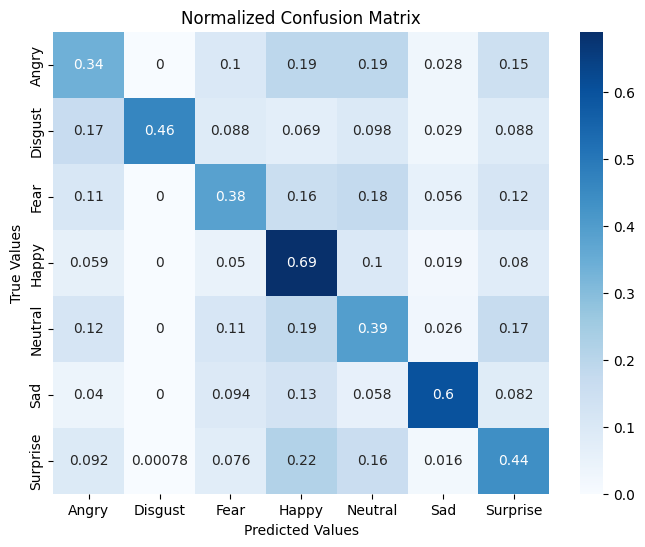

              precision    recall  f1-score   support

       Angry       0.39      0.34      0.36       985
     Disgust       0.98      0.46      0.63       102
        Fear       0.44      0.38      0.41      1043
       Happy       0.56      0.69      0.62      1765
     Neutral       0.37      0.39      0.38      1210
         Sad       0.73      0.60      0.66       795
    Surprise       0.45      0.44      0.44      1278

    accuracy                           0.49      7178
   macro avg       0.56      0.47      0.50      7178
weighted avg       0.49      0.49      0.49      7178



In [ ]:
# creating confusion matrix
public_cm = confusion_matrix(testY, y_pred, normalize='true')

# plotting normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(public_cm, cmap='Blues', annot=True, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Normalized Confusion Matrix')
plt.show()

# creating classification report
public_cr = classification_report(testY, y_pred, target_names=label_names)
print(public_cr)

### MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
def objective(trial):

    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes',
                                                   [ (512, 128, 64),
                                                    (512, 64,7), (1024,512 , 128), (1024, 512, 128,7)])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd', 'lbfgs'])
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])


    model= make_pipeline(StandardScaler(),
                         PCA(150),
                          MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation,
                          solver=solver, alpha=alpha, learning_rate=learning_rate,
                          max_iter=200, random_state=42))


    model.fit(trainX, trainY)


    y_pred = model.predict(testX)


    acc = accuracy_score(testY, y_pred)

    return acc




In [ ]:
# Create the study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, n_jobs=-1)

[I 2024-06-21 03:51:49,638] A new study created in memory with name: no-name-2888ce2f-b291-4ef2-8708-cfa7cb5f903f
[I 2024-06-21 04:22:21,262] Trial 1 finished with value: 0.4521254355400697 and parameters: {'hidden_layer_sizes': (1024, 512, 128), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.00019708259480729834, 'learning_rate': 'constant'}. Best is trial 1 with value: 0.4521254355400697.
[I 2024-06-21 04:40:00,487] Trial 2 finished with value: 0.4143554006968641 and parameters: {'hidden_layer_sizes': (512, 64, 7), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.08163438435059801, 'learning_rate': 'constant'}. Best is trial 1 with value: 0.4521254355400697.
[I 2024-06-21 04:54:10,300] Trial 0 finished with value: 0.443205574912892 and parameters: {'hidden_layer_sizes': (1024, 512, 128, 7), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0020677554767015087, 'learning_rate': 'adaptive'}. Best is trial 1 with value: 0.4521254355400697.
[I 2024-06-21 05:04:27,685] Trial 3 fi

In [ ]:
study.best_params

{'hidden_layer_sizes': (1024, 512, 128, 7),
 'activation': 'relu',
 'solver': 'adam',
 'alpha': 3.137217831343239e-05,
 'learning_rate': 'adaptive'}

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
def build_model(X, y):
    """
    Design your model and train it (including your best params)
    :param X: feature matrix
    :param y: target
    :return: a model
    """


    model = make_pipeline(
                          PCA(n_components=150),
                          StandardScaler(),
                          MLPClassifier())

    param_grid = {
        'mlpclassifier__hidden_layer_sizes': [(512, 64, 7), (1024,512,128,7)],
        'mlpclassifier__activation': ['tanh', 'relu'],
        'mlpclassifier__solver': ['adam'],
        'mlpclassifier__alpha': [1e-5, 3.13e-5],
        'mlpclassifier__learning_rate': ['adaptive'],
    }

    grid_search = GridSearchCV(model, param_grid, cv=2, n_jobs=-1)
    grid_search.fit(X,y)

    return grid_search

In [ ]:
model=build_model(trainX,trainY)

In [ ]:
model.best_params_

{'mlpclassifier__activation': 'relu',
 'mlpclassifier__alpha': 3.13e-05,
 'mlpclassifier__hidden_layer_sizes': (1024, 512, 128, 7),
 'mlpclassifier__learning_rate': 'adaptive',
 'mlpclassifier__solver': 'adam'}

In [ ]:
best_model = model.best_estimator_


In [ ]:
pred=best_model.predict(testX)
print(classification_report(testY, pred))
print(confusion_matrix(testY, pred))

              precision    recall  f1-score   support

           0       0.29      0.32      0.31       931
           1       0.45      0.39      0.41       101
           2       0.31      0.39      0.34      1021
           3       0.59      0.57      0.58      1811
           4       0.35      0.31      0.33      1236
           5       0.73      0.57      0.64       822
           6       0.38      0.40      0.39      1253

    accuracy                           0.44      7175
   macro avg       0.44      0.42      0.43      7175
weighted avg       0.45      0.44      0.44      7175

[[ 297    5  143  142  147   27  170]
 [  16   39   12   10   12    3    9]
 [ 152   12  397  114  155   55  136]
 [ 158   15  144 1040  191   30  233]
 [ 174    9  279  196  378   25  175]
 [  41    5  119   57   46  466   88]
 [ 173    2  202  195  144   31  506]]


_________________________
### XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score


def objective(trial):
    params = {
        "device": "cuda",
        "objective": trial.suggest_categorical("objective", ["multi:softmax", "multi:softprob", "ovr"]),
        "n_estimators": 150,
        "gamma": trial.suggest_float("gamma", 0, 10),
        "verbosity": 1,
        "eta": trial.suggest_float("eta", 0, 1),
        "alpha": trial.suggest_float("alpha", 0, 10),
        "lambda": trial.suggest_float("lambda", 0, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.5, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 15),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
   }

    model=make_pipeline(
                       PCA(n_components=150),
                        StandardScaler(),
                       xgb.XGBClassifier(**params)
                       )


    model.fit(trainX, trainY)
    y_pred = model.predict(testX)
    accuracy = accuracy_score(testY, y_pred)
    return accuracy

In [ ]:
%%time
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, n_jobs = -1)

[I 2024-06-21 06:03:22,864] A new study created in memory with name: no-name-b2913df3-446e-4944-b1af-e5a2c5e85811
[I 2024-06-21 06:04:07,289] Trial 2 finished with value: 0.2972972972972973 and parameters: {'objective': 'multi:softprob', 'gamma': 7.497405283449561, 'eta': 0.8788978063276777, 'alpha': 9.153414665207094, 'lambda': 2.003475232596892, 'learning_rate': 0.008421599546871533, 'max_depth': 2, 'subsample': 0.908603276269377, 'colsample_bytree': 0.8069876393230309}. Best is trial 2 with value: 0.2972972972972973.
[I 2024-06-21 06:04:16,592] Trial 1 finished with value: 0.3719699080523823 and parameters: {'objective': 'multi:softmax', 'gamma': 2.0519745711327317, 'eta': 0.879630855181338, 'alpha': 5.965302757628841, 'lambda': 9.513766323928532, 'learning_rate': 0.16755996170597368, 'max_depth': 9, 'subsample': 0.08939926652139019, 'colsample_bytree': 0.38759902039682526}. Best is trial 1 with value: 0.3719699080523823.
[I 2024-06-21 06:04:30,294] Trial 4 finished with value: 0.24

CPU times: user 12min 14s, sys: 3min 1s, total: 15min 15s
Wall time: 4min 6s


In [ ]:
study.best_params

{'objective': 'ovr',
 'gamma': 0.21229827373947696,
 'eta': 0.03235062226272928,
 'alpha': 3.9492779730976357,
 'lambda': 0.4027526254290148,
 'learning_rate': 0.09079209426884079,
 'max_depth': 8,
 'subsample': 0.9611680106565006,
 'colsample_bytree': 0.5125962736194493}

In [ ]:
model=make_pipeline(
                   PCA(n_components=150),
                    StandardScaler(),
                   xgb.XGBClassifier(**study.best_params)
                   )
model.fit(trainX, trainY)
y_pred = model.predict(testX)

In [ ]:
print(classification_report(testY, y_pred))
print(confusion_matrix(testY, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.21      0.28       985
           1       1.00      0.19      0.31       102
           2       0.47      0.26      0.34      1043
           3       0.43      0.76      0.55      1765
           4       0.35      0.37      0.36      1210
           5       0.68      0.52      0.59       795
           6       0.41      0.35      0.38      1278

    accuracy                           0.44      7178
   macro avg       0.54      0.38      0.40      7178
weighted avg       0.46      0.44      0.42      7178

[[ 202    0   70  349  198   34  132]
 [  13   19    9   34   11    4   12]
 [  62    0  275  331  176   68  131]
 [  40    0   51 1336  197   37  104]
 [  64    0   75  397  453   22  199]
 [  27    0   53  169   62  417   67]
 [  52    0   58  474  216   28  450]]


## 4 . Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



1. With PCA dataset

| **Model**                    |  **Accuracy** | **Precision** |**Recall**|**F1**|
|:-----------------------------|:----------------------------:|:-:|:-:|:-:|
| Logistic Regression          |0.37|0.37 |     0.30     | 0.30|
| Decision Tree                |0.29|0.28 |     0.29  |    0.28 |
| Random Forest                |0.44| 0.62 |     0.38  |    0.42 |
| Support Vector Machine (SVM) |0.5|0.56  |    0.47   |   0.50 |
| Multi-layer Perceptron (MLP) |0.44|0.44   |   0.42  |    0.43 |
| XGBoost Classifier           |0.44| 0.54 |     0.38  |    0.40|


2. Original Dataset with HOG features


| **Model**                    |  **Accuracy** | **Precision** |**Recall**|**F1**|
|:-----------------------------|:----------------------------:|:-:|:-:|:-:|
| Logistic Regression          |0.42| 0.36|      0.38  |    0.36|
| Decision Tree                |0.31|0.30  |    0.31   |   0.30|
| Random Forest                |0.48|0.57   |   0.43  |    0.45 |
| **Support Vector Machine (SVM)** |0.57|0.60    |  0.54   |   0.56|
| Multi-layer Perceptron (MLP) |0.48|0.48   |   0.48  |    0.48|
| XGBoost Classifier           |0.49| 0.52   |   0.42    |  0.43  |

 Based on the evaluation metrics, explain which model performs best and why ?


 Base on the evaluation metrics, model performs best is SVM.
 Because:

-  Handling High-Dimensional Data: SVM finds the optimal hyperplane in high-dimensional feature space, suitable for image data with many pixels.

- Kernel Trick: Effectively handles nonlinear relationships between pixels and facial expressions.

- Focus on Support Vectors: Makes SVM robust to outliers by concentrating on the most critical data points.

- Reliability and Efficiency: SVM provides clear decision boundaries between diverse facial expression classes, making it effective for classifying various facial expressions.



 Identify the emotion category where the model makes the most accurate and most errors.

**The most accurate**: Happy. Distinctive Features: The "Happy" emotion typically includes clear and distinctive facial features like a smile, which is easily recognizable by models. High Contrast: The "Happy" expression contrasts significantly with other emotions, reducing the likelihood of confusion.


**The most errors**: Disgust, Fear, Sad. Subtle Features: Emotions like "Disgust," "Fear," and "Sad" often have subtle facial expressions that are harder to distinguish. These subtle differences can lead to higher error rates. Overlapping Features: These emotions can share common facial features with other emotions, increasing the chances of misclassification.


- Angry easily confused with Sad

- Disgust easily confused with Angry

- Fear easily confused with Sad

- Sad easily confused with Neutral, Angry

- Neutral easily confused with Surprise, Sad



In [ ]:
## visualize the confusion matrices and classification reports here

In [ ]:
#Visualize Good Model

In [ ]:
from cuml.svm import SVC as cuSVC
from sklearn.model_selection import GridSearchCV

In [ ]:
model = cuSVC(C= 0.1, class_weight= 'balanced', degree = 6, kernel= 'poly')
model.fit(hog_features, y_train_augmented)

SVC()

In [ ]:
y_pred = model.predict(Xtest)

In [ ]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.46      0.47       988
           1       0.85      0.54      0.66       105
           2       0.47      0.42      0.44      1031
           3       0.73      0.73      0.73      1756
           4       0.44      0.45      0.45      1267
           5       0.72      0.68      0.70       797
           6       0.50      0.58      0.53      1231

    accuracy                           0.57      7175
   macro avg       0.60      0.55      0.57      7175
weighted avg       0.57      0.57      0.57      7175

[[ 454    6   91  100  169   34  134]
 [  24   57    6    5    9    1    3]
 [ 101    3  435   72  194   91  135]
 [  94    0   72 1281  120   41  148]
 [ 141    1  162  122  573   27  241]
 [  34    0   78   49   27  545   64]
 [  90    0   84  128  197   21  711]]


In [ ]:
pred = model.predict(hog_features)
print("Train set")
main_score=calculate_performance(y_train_augmented,pred)

print("="*80)
pred = model.predict(Xtest)
print("Test set")
main_score=calculate_performance(y_test,pred)

Train set
________________________________________________________________________________
| Accuracy:  0.999150445092897
| Precision (weighted):  0.9991508416985321
| Recall (weighted):  0.999150445092897
| F1 Score (weighted):  0.9991504011805692
________________________________________________________________________________
| Precision (macro):  0.9991217983234888
| Recall (macro):  0.9992183778580691
| F1 Score (macro):  0.9991698227757964
________________________________________________________________________________
| Precision (micro):  0.999150445092897
| Recall (micro):  0.999150445092897
| F1 Score (micro):  0.999150445092897
________________________________________________________________________________
Test set
________________________________________________________________________________
| Accuracy:  0.5652961672473867
| Precision (weighted):  0.5679907282473646
| Recall (weighted):  0.5652961672473867
| F1 Score (weighted):  0.5653315394363878
_______________________

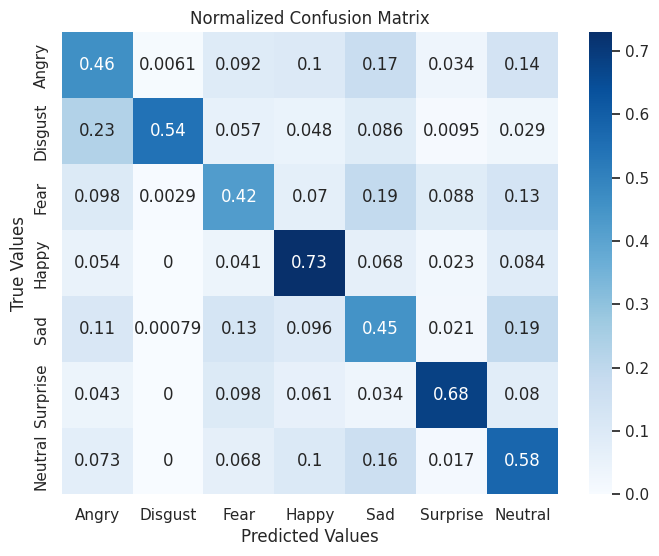

              precision    recall  f1-score   support

       Angry       0.48      0.46      0.47       988
     Disgust       0.85      0.54      0.66       105
        Fear       0.47      0.42      0.44      1031
       Happy       0.73      0.73      0.73      1756
         Sad       0.44      0.45      0.45      1267
    Surprise       0.72      0.68      0.70       797
     Neutral       0.50      0.58      0.53      1231

    accuracy                           0.57      7175
   macro avg       0.60      0.55      0.57      7175
weighted avg       0.57      0.57      0.57      7175



In [ ]:
# creating confusion matrix
public_cm = confusion_matrix(y_test, y_pred, normalize='true')

# plotting normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(public_cm, cmap='Blues', annot=True, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Normalized Confusion Matrix')
plt.show()

# creating classification report
public_cr = classification_report(y_test, y_pred, target_names=label_names)
print(public_cr)

## 5 . Test_model

In [ ]:
image_test=X_test[75:100]

test_hog,_= preprocess_with_hog(image_test)

100%|██████████| 25/25 [00:00<00:00, 75.13it/s]


In [ ]:
pred=model.predict(test_hog)

In [ ]:
import matplotlib.pyplot as plt
def plot_test_model(images, labels, preds, n_images):

    label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(25, 20))

    for i in range(rows*cols):
        color='green'
        if labels[i]!=preds[i]:
            color='red'
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i],cmap='gray')
        ax.set_title(f'True Label: {label_names[labels[i]]}\n'
                     f'Pred Label: {label_names[preds[i]]} \n', color=color)
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

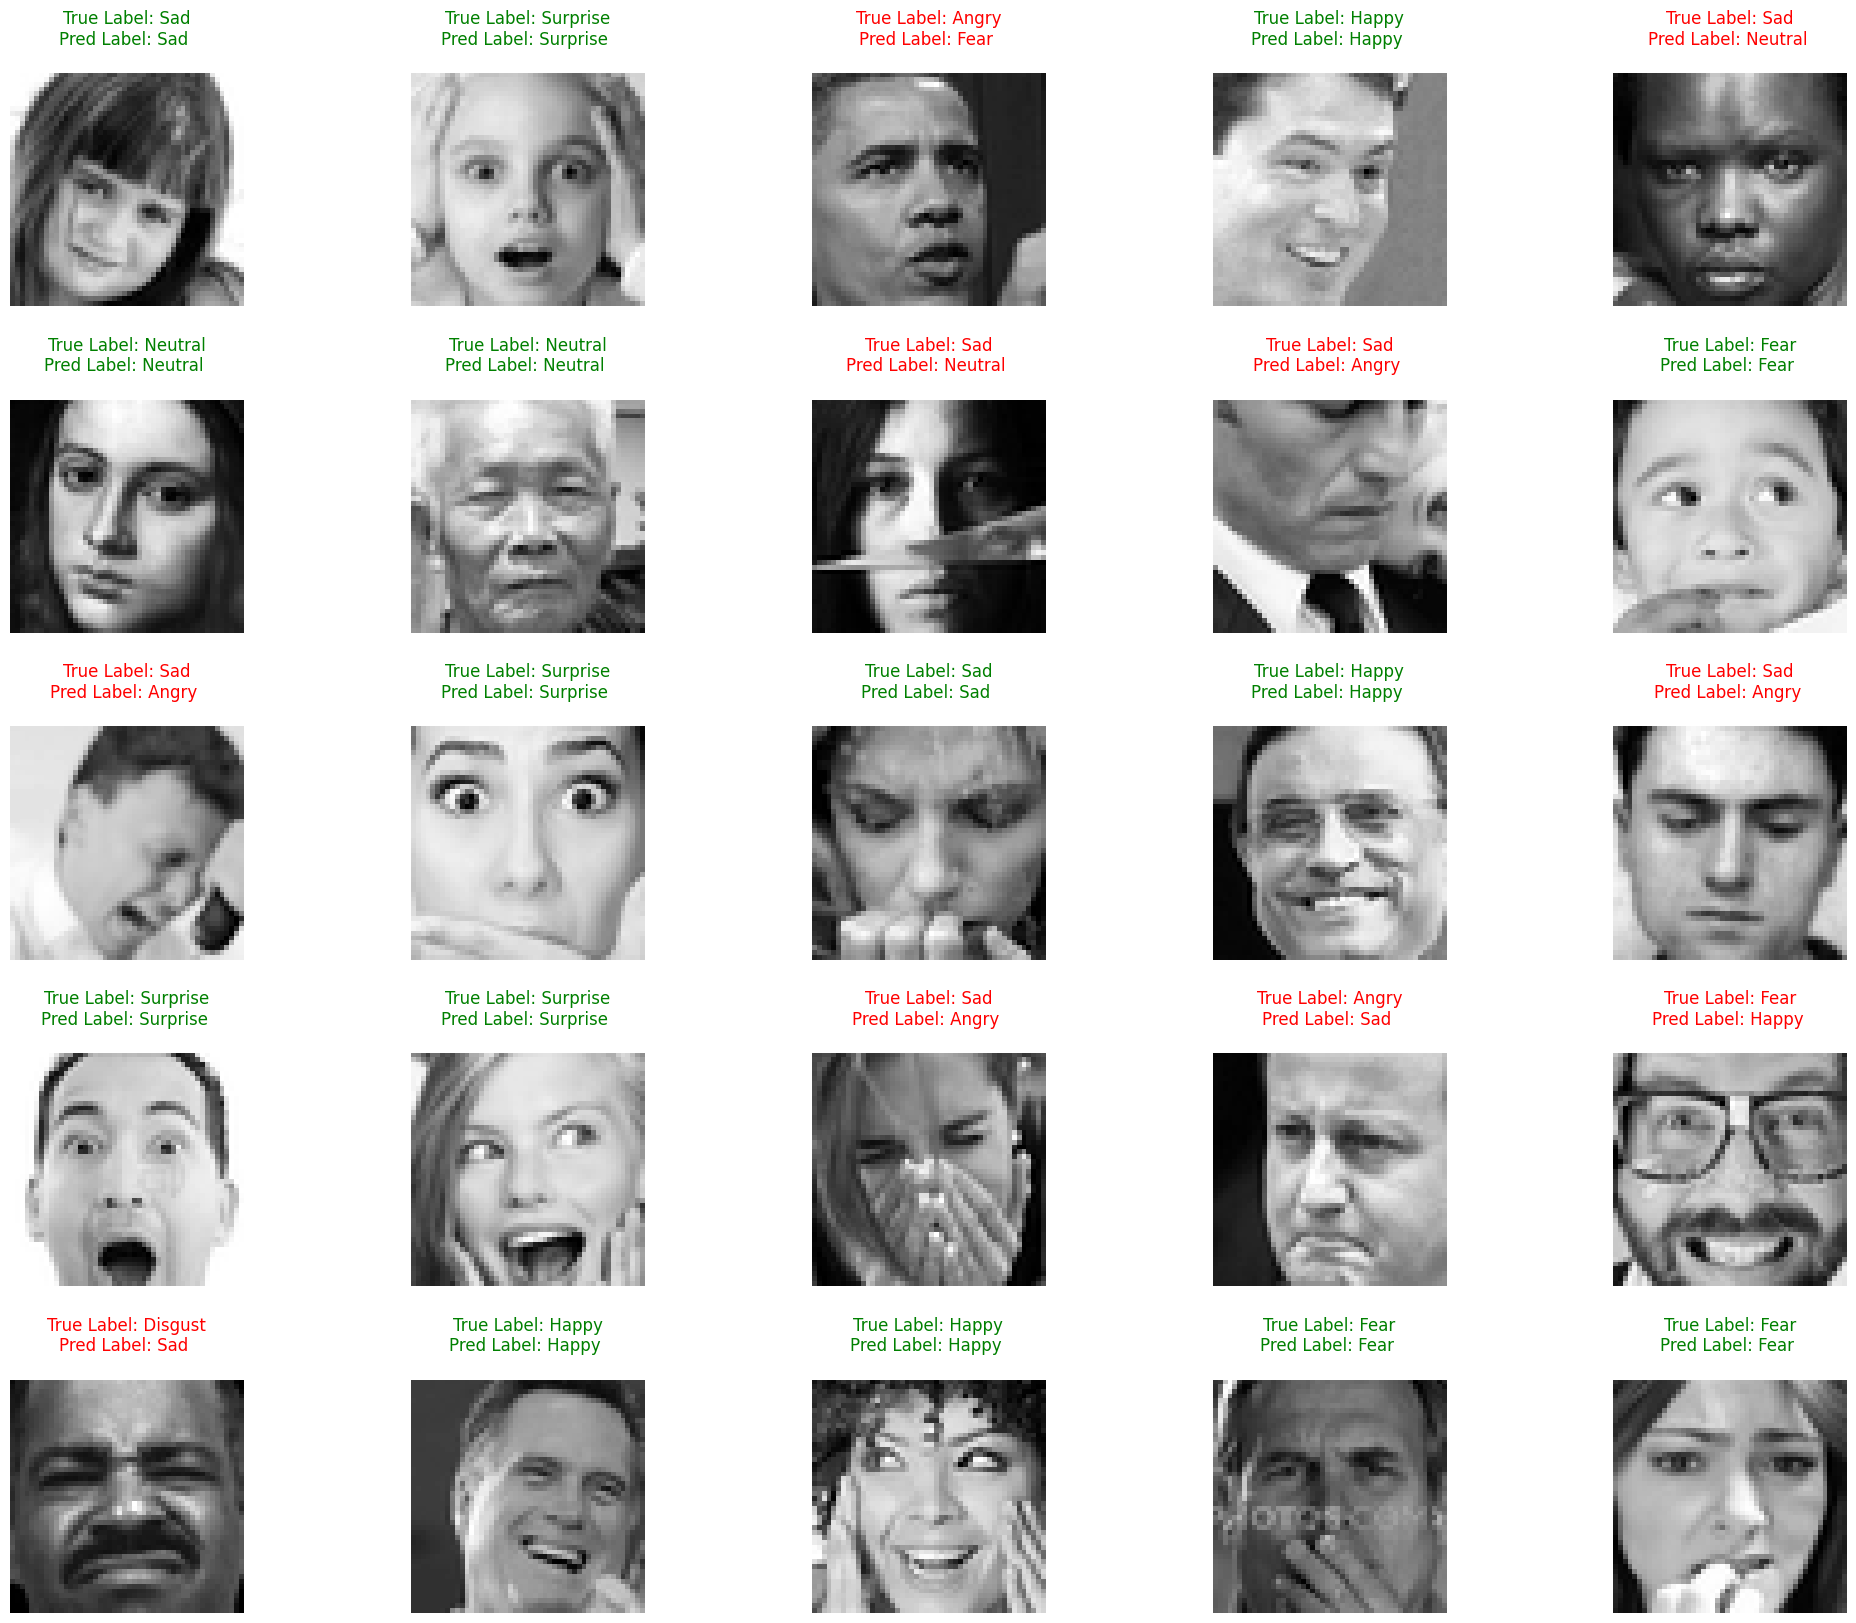

In [ ]:
plot_test_model(X_test[75:100], y_test[75:100], pred, n_images=25)

## 6 . Challenges in Facial Expression Recognition (FER)

-  Subjectivity:  Recognizing subtle and non-prototypical emotions (e.g., contempt, attentiveness).


-  Illumination: Variations in lighting conditions affect feature extraction, leading to misclassification.


- Occlusion: Objects covering parts of the face lead to loss of critical features and degrade system performance.


- Pose Variation Changes in head pose (self-occlusion) hinder recognition, as most systems are designed for frontal views.

